# Imports

In [0]:
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.neighbors import KNeighborsClassifier
import math, random
import numpy as np
import sys
import os
from tqdm import tqdm

#Load Corpus


In [2]:
drive.mount('/drive')
os.system('unzip /drive/Mydrive/ORLProcessed.zip')

def readpgm(name):
    with open(name) as f:
        lines = f.readlines()

    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    assert lines[0].strip() == 'P2' 

    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])

    return (np.array(data[3:]),(data[1],data[0]),data[2])

def get_images(folder, comment):
  X = []
  y = []
  for l in tqdm(range(1,41), desc=comment):
    path = folder + '/s' + str(l)
    for i in os.listdir(path):
      image = readpgm(path+'/'+i)
      if image != None:
        X.append(np.reshape(image[0],image[1]))
        y.append(str(l))
  X = np.array(X)
  y = np.array(y)
  return X,y

x_train, y_train = get_images('/drive/My Drive/ORLProcessed/Train', 'Train corpus')
x_test, y_test = get_images('/drive/My Drive/ORLProcessed/Test', 'Test corpus')

print('To train: ')
print(x_train.shape)
print(y_train.shape)


print('To test: ')
print(x_test.shape)
print(y_test.shape)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


Train corpus:   0%|          | 0/40 [00:00<?, ?it/s]

Mounted at /drive


Test corpus: 100%|██████████| 40/40 [01:30<00:00,  2.25s/it]

To train: 
(200, 112, 92)
(200,)
To test: 
(200, 112, 92)
(200,)


# Show me a random picture

[[143 144 142 ... 147 144 141]
 [145 141 144 ... 146 145 142]
 [144 143 143 ... 147 143 144]
 ...
 [213 223 222 ...  83  78  75]
 [223 222 221 ...  79  79  80]
 [222 222 220 ...  79  79  80]]


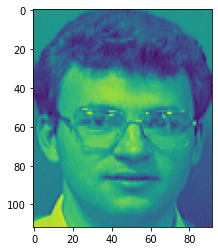

In [3]:
rand_im = x_train[random.randint(0,len(x_train)-1)]
plt.imshow(rand_im)
print(rand_im)

# Matrix Transform

In [4]:
x_train = np.matrix([x.flatten() for x in x_train])
x_test = np.matrix([x.flatten() for x in x_test])
print(x_train.shape)
print(x_test.shape)

(200, 10304)
(200, 10304)


# PCA

In [0]:
def PCA(X):
  X = X.T

  mean = X.mean(axis=1)

  A = X - mean
  d = A.shape[0]
  n = A.shape[1]
  # print('Matriz A: ', A.shape)
  # print('d = ', d)
  # print('n = ', n)

  C = 1/float(d) * A.T * A
  
  # print('Matriz de covarianzas: ', C.shape)

  Delta_prime,B_prime = np.linalg.eigh(C)

  B = A * B_prime
  Delta = (float(d)/float(n)) * Delta_prime

  e_vectoresOrdered = sorted(list(enumerate(Delta)), key=lambda l:l[1] , reverse=True)

  B_res = []
  for i,d in e_vectoresOrdered:#e_vectoresOrdered es de la forma (indice, eigenvalue)
    B_res.append(B[:,i] / np.linalg.norm(B[:,i]))
  B_res = np.matrix(np.array(B_res)).T
  # print('Eigen Vectores Ordenados: ', B_res.shape)

  return B_res

# PCA Reduction

In [0]:
def reduce_PCA(data, eigenvectores, components):
  data = data.T
  vectores = eigenvectores[:,:components]
  data = data - data.mean(axis=1)
  res = vectores.T * data
  res = res.T
  return res

# LDA

In [0]:
def LDA(X, labels):
  X = X.T
  # print('Data input: ', X.shape)

  #General mean and dimensions
  mean = X.mean(axis=1)
  d = X.shape[0]
  n = X.shape[1]
  # print('d = ', d)
  # print('n = ', n)

  #Mean for c
  means_c = []
  for i in range(40):
    means_c.append(X[:,i*5:(i*5)+5].mean(axis=1))
  means_c = np.matrix(np.array(means_c)).T
  # print('Matriz de medias: ', means_c.shape)

  #Sb calcs
  S_b_aux = means_c - mean
  S_b = 5 * S_b_aux * S_b_aux.T
  # print("Sb: ", S_b.shape)

  #Sw calcs
  S_w_aux = X[:,0:5] - means_c[:,0]
  S_w = S_w_aux * S_w_aux.T
  if(d > 1):
    for i in range(1,40):
      S_w_aux = X[:,i*5:(i*5)+5] - means_c[:,i]
      S_w += S_w_aux * S_w_aux.T
  # print("Sw: ", S_w.shape)

  #Eigenvectors Calcs
  C = S_w.I * S_b
  # print('Matriz de covarianzas: ', C.shape)

  Delta, B = np.linalg.eigh(C)

  e_vectoresOrdered = sorted(list(enumerate(Delta)), key=lambda l:l[1] , reverse=True)

  B_res = []
  for i,d in e_vectoresOrdered:#e_vectoresOrdered es de la forma (indice, eigenvalue)
    B_res.append(B[:,i])
  B_res = np.matrix(np.array(B_res)).T
  # print('Eigen Vectores Ordenados: ', B_res)

  return B_res

# LDA Reduction

In [0]:
def reduce_LDA(data, eigenvectores, components):
  data = data.T
  vectores = eigenvectores[:,:components]
  res = vectores.T * data
  res = res.T
  return res

# Loop of tries

In [9]:
#PCA eigenvectors
x_plots = []
y_plots = []
evecs_pca = PCA(x_train.copy())
best_accuracy = 0;
dimension_pca = 0;
dimension_lda = 0;
for n_pca in range(2,201):
  #PCA Reduce
  train_reduced_pca = reduce_PCA(x_train.copy(), evecs_pca.copy(), n_pca)
  test_reduced_pca = reduce_PCA(x_test.copy(), evecs_pca.copy(), n_pca)
  #LDA eigenvectors
  evecs_lda = LDA(train_reduced_pca.copy(), y_train)
  for n_lda in range(1,n_pca+1):
    #LDA Reduce
    train_reduced_lda = reduce_LDA(train_reduced_pca.copy(), evecs_lda.copy(), n_lda)
    test_reduced_lda = reduce_LDA(test_reduced_pca.copy(), evecs_lda.copy(), n_lda)
    #Model classifier created(1-NN)
    neigh = KNeighborsClassifier(n_neighbors=1)
    #Train
    neigh.fit(train_reduced_lda, y_train)
    #Test
    score = neigh.score(test_reduced_lda, y_test)
    if(n_pca == 183):
      x_plots.append(n_lda)
      y_plots.append(score)
    print('For dimension in PCA= ', n_pca, ', dimension in LDA= ', n_lda, ', accuracy= ', score)
    if(score > best_accuracy):
      best_accuracy = score
      dimension_pca = n_pca
      dimension_lda = n_lda
print('##############################################################################################')
print('##############################################################################################')
print('Best Score = ', best_accuracy, ", at dimension in PCA = ", dimension_pca, " and dimension in LDA = ", dimension_lda)
print('##############################################################################################')
print('##############################################################################################')

Se han truncado las últimas 5000 líneas del flujo de salida.
For dimension in PCA=  174 , dimension in LDA=  56 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  57 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  58 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  59 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  60 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  61 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  62 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  63 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  64 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  65 , accuracy=  0.9
For dimension in PCA=  174 , dimension in LDA=  66 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  67 , accuracy=  0.895
For dimension in PCA=  174 , dimension in LDA=  68 , accuracy=  0.905
For dimension in PCA=  174 , di

# Plot Graphics

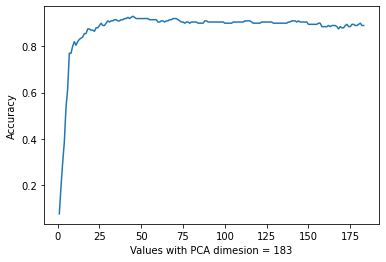

In [13]:
plt.xlabel('Values with PCA dimesion = 183')
plt.ylabel('Accuracy')
plt.plot(x_plots, y_plots)
plt.show()